# Use PyPSA for a network

This example aims at proposing a sample optimization using PyPSA for a network of 4 nodes with the following structure:

1 (PV+Battery) ------ 2 (Load) ------ 3 (Load+Diesel) ------ 4 (Wind)

where numbers denote the node, the dashed lines represent the lines and the labels in brackets denote the type of generators, loads or storage.

Input data are contextualized for a PV-Wind-Diesel microgrid in Soroti, Uganda, (1.7250° N, 33.6208° E).


The procedure leverages on:
- the case study presented in [D. Fioriti et. al, 2022, Multiple design options for sizing off-grid microgrids: A novel single-objective approach to support multi-criteria decision making, Sustainable Energy, Grids and Networks](https://doi.org/10.1016/j.segan.2022.100644),
- complemented with the wind parameters highligted in [D. Fioriti et al, Coupling economic multi-objective optimization and multiple design options: A business-oriented approach to size an off-grid hybrid microgrid, 2021, IJEPES](https://doi.org/10.1016/j.ijepes.2020.106686)

In particular, the following data sources are used:
- **Demand**: the demand inputs are obtained from the paper (D. Fioriti et. al, 2022) referenced above
- **PV and Wind**: the solar photovoltaic (PV) and wind time series are obtained using the [Renewable.ninja platform](https://renewables.ninja/), heavily backed by strong scientific background (see [documentation](https://renewables.ninja/documentation/)); the cost parameters are those of the paper (D. Fioriti et. al, 2021)
- **Other cost assumptions**: based on the paper (D. Fioriti et. al, 2021)

## Package imports

Section to first import the major packages used in the notebook.
Note: the PyPSA-Earth environment is suitable to run this notebook.

In [1]:
# package to handle efficient numeric structures (vectors/matrices) mathematical operations
import numpy as np
# package to handle databases, e.g. tabular data
import pandas as pd
# energy modelling package
import pypsa
# package to make plots
import matplotlib.pyplot as plt

Some global constants used for simplifying the code

In [2]:
# figure size
FIGSIZE = (5, 2.5)
# solver of the optimization
SOLVER = "glpk"
# number of buses
n_buses = 4
# number of loads
n_loads = 2
# gps coordinates of the buses
x, y = 33.6208, 1.7250
# set random seed for reproducibility
np.random.seed(0)
# number of representative days
N_DAYS = 12

## 1. Data import

### PV

The available PV production for every hour of 2019 is estimated using Renewables.ninja platform, using standard inputs for the PV plant (tilt angle, orientation, etc.).
The data are downloaded manually and loaded into the data folder with name `ninja_pv_1.7250_33.6208_uncorrected.csv`.

In the following, the file is loaded also including some plottings for easy visualization.

In [3]:
# file name of the pv data
pv_file = 'data/ninja_pv_1.7250_33.6208_uncorrected.csv'

# Load the CSV file
df_pv = pd.read_csv(pv_file, skiprows=3)  # skip the first 3 rows
df_pv.rename(columns={'electricity': 'pv'}, inplace=True)  # rename the electricity column

### Wind

The available wind production for every hour of 2019 is estimated using Renewables.ninja platform, using standard inputs for the PV plant (tilt angle, orientation, etc.).
The data are downloaded manually and loaded into the data folder with name `ninja_wind_1.7250_33.6208_uncorrected.csv`.

In the following, the file is loaded also including some plottings for easy visualization.

In [4]:
# file name of the pv data
wind_file = 'data/ninja_wind_1.7250_33.6208_uncorrected.csv'

# Load the CSV file
df_wind = pd.read_csv(wind_file, skiprows=3)  # skip the first 3 rows
df_wind.rename(columns={'electricity': 'wind'}, inplace=True)  # rename the electricity column

### Load

The load demand is obtained from the paper by D.Fioriti et al.

In the activity, a so-called 'typical daily' profile was estimated using the tool LoadProGen, now available as [RAMP](https://rampdemand.org/).

In the data folder, the file `demand_data.csv` contains the following two columns:
1. the first column is the average demand for every hour of the day
2. the second column is the standard deviation of the demand for every hour of the day

In [5]:
# file name of the pv data
demand_file = 'data/demand_data.csv'

# Load the CSV file
df_demand_day = pd.read_csv(demand_file)
df_demand_day["hour"] = range(0, 24)

confidence_factor = 1.96  # 95% confidence interval

Note that in typical offgrid systems, in first approximation, the demand is assumed to be invariant over the year.

Therefore, in the following, we generate a yearly time series of demand by randomly sampling the demand for every hour of the day from a normal distribution with mean and standard deviation as above.

In particular, we now create a pandas dataframe with one column for each demand loads.

In [6]:
n_days = 365  # number of days to simulate

df_demand = pd.DataFrame(index=df_pv.index)

for i in range(n_loads):
    df_demand_year = np.random.normal(
        np.tile(df_demand_day["demand"], n_days),
        np.tile(df_demand_day["standard_deviation"], n_days),
    )
    df_demand.loc[:, f"demand {i+1}"] = df_demand_year

In the following, we show a plot of the entire dataset to show the variability of the time series.

The yearly plot is then the following

Text(0, 0.5, 'Demand [kW]')

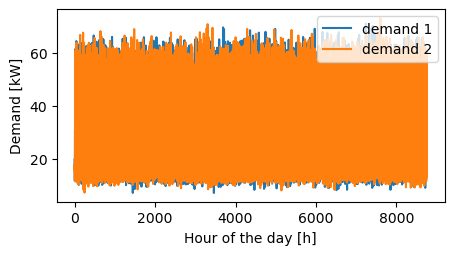

In [7]:
# plot the demand
plt.figure(figsize=FIGSIZE)
plt.plot(df_demand)
plt.legend(df_demand.columns)
plt.xlabel("Hour of the day [h]")
plt.ylabel("Demand [kW]")

For simplicity, all time series data are now aggregated into a single dataframe for simplicity

In [8]:
# merge the data into one dataframe
df_data = pd.concat(
    [df_pv[["pv"]], df_wind[["wind"]], df_demand],
    axis=1,
)

## 2. Create input cost parameters

This section aims at describing the cost parameters used in the optimization.

To do so, the goal is to create a dataframe of major input parameters, for each technology, including:
- **CAPEX**: capital expenditure
- **OPEX**: operational expenditure, divided into two independent components:
    - ***Fixed* OPEX**: expenditure *independent* from the energy production
    - ***Marginal* OPEX**: expenditure *dependent* from the energy production
- **Lifetime**: lifetime of the technology
- **Efficiency**: efficiency of the technology
- **Discount rate**: discount rate of the analysis

In [9]:
# Initialize the dataframe: columns indicate cost components and rows indicate technologies
assumptions = pd.DataFrame(
    columns=["CAPEX", "discount rate", "efficiency", "OPEX_fixed", "OPEX_marginal", "lifetime"],
    index=["default", "pv", "wind", "battery", "diesel"],
)

# default parameters
assumptions.at["default", "OPEX_fixed"] = 3.0
assumptions.at["default", "OPEX_marginal"] = 0.0
assumptions.at["default", "discount rate"] = 0.08
assumptions.at["default", "lifetime"] = 20

# pv technology
assumptions.at["pv", "CAPEX"] = 900  # EUR/kWp
assumptions.at["pv", "OPEX_fixed"] = 16  # EUR/kWp/year
assumptions.at["pv", "lifetime"] = 25  # years

# wind technology
assumptions.at["wind", "CAPEX"] = 2400  # EUR/kWp
assumptions.at["wind", "OPEX_fixed"] = 80  # EUR/kWp/year
assumptions.at["wind", "lifetime"] = 20  # years

# battery technology
assumptions.at["battery", "CAPEX"] = 450  # EUR/kWh
assumptions.at["battery", "OPEX_fixed"] = 3  # EUR/kWh/year
assumptions.at["battery", "efficiency"] = 0.9  # [-] per unit
assumptions.at["battery", "lifetime"] = 10  # years

# diesel technology
fuel_price = 1.4  # EUR/l
fuel_energy_density = 10  # kWh/l
efficiency_diesel = 0.33  # [-] per unit

maintenance_diesel = 0.05  # EUR/kW/h

assumptions.at["diesel", "CAPEX"] = 6e2  # EUR/kW
assumptions.at["diesel", "OPEX_marginal"] = \
    (fuel_price / fuel_energy_density / efficiency_diesel + maintenance_diesel)  # EUR/kWh
assumptions.at["diesel", "lifetime"] = 3  # years

# fill defaults
assumptions = assumptions.fillna(
    {
        "OPEX_fixed": assumptions.at["default", "OPEX_fixed"],
        "OPEX_marginal": assumptions.at["default", "OPEX_marginal"],
        "discount rate": assumptions.at["default", "discount rate"],
        "lifetime": assumptions.at["default", "lifetime"],
    }
)

# save to file
assumptions.to_csv("assumptions.csv")

assumptions

C:\Users\Davide\AppData\Local\Temp\ipykernel_56912\2486677952.py:42: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



,CAPEX,discount rate,efficiency,OPEX_fixed,OPEX_marginal,lifetime
default,NaN,0.08,NaN,3.0,0.000000,20
pv,900,0.08,NaN,16.0,0.000000,25
wind,2400,0.08,NaN,80.0,0.000000,20
battery,450,0.08,0.9,3.0,0.000000,10
diesel,600.0,0.08,NaN,3.0,0.474242,3


The objective of the system is to minimize the annualized costs, which are computed as follows:

$$
\text{Annualized costs} = OPEX + \sum_{i \in A} {CRF}_i * {CAPEX}_i\\
CRF_i = \frac{r(1+d)^{L_i}}{(1+d)^{L_i}-1}
$$

where:
- $A$ is the set of technologies
- $d$ is the discount rate
- $L_i$ is the lifetime of the technology $i$

In [10]:
def annuity(lifetime, rate):
    """
    Calculate the annuity factor for a given lifetime and discount rate.
    """
    if rate == 0.0:
        return 1 / lifetime
    else:
        return rate / (1.0 - 1.0 / (1.0 + rate) ** lifetime)


# calculate annuity for every technology
assumptions["annuity"] = assumptions.apply(
    lambda x: annuity(x["lifetime"], x["discount rate"]), axis=1
)

# annualise investment costs, add fixed OPEX to calculate the parameter `capital_cost` for the PyPSA model
assumptions["capital_cost"] = [
    v["annuity"] * v["CAPEX"] + v["OPEX_fixed"]
    for i, v in assumptions.iterrows()
]

assumptions

,CAPEX,discount rate,efficiency,OPEX_fixed,OPEX_marginal,lifetime,annuity,capital_cost
default,NaN,0.08,NaN,3.0,0.000000,20,0.101852,NaN
pv,900,0.08,NaN,16.0,0.000000,25,0.093679,100.310901
wind,2400,0.08,NaN,80.0,0.000000,20,0.101852,324.445301
battery,450,0.08,0.9,3.0,0.000000,10,0.149029,70.063270
diesel,600.0,0.08,NaN,3.0,0.474242,3,0.388034,235.820108


## 3. PyPSA model

This second block of code is used to define the PyPSA model.

The model is a N-node energy system that contains the following components:
- **Load**: the load is defined as a fixed **Load** component, with the time series of demand as defined above. The load is attached to nodes 2 and 3
- **PV**: the PV is defined as a **Generator** and attached to node 1
- **Battery**: the battery is defined as a **Storage Unit** and attached to node 1
- **Wind**: the wind is defined as a **Generator** and attached to node 4
- **Diesel**: the diesel generator is defined as a **Generator** and attached to node 3

All assets (PV, Wind, Battery and Diesel generator) are assumed to be expandable: the optimization will determine the optimal size of each asset.
*Note*: we assume that the costs of components are linearly to their capacity.

### Create the basic PyPSA model

In [11]:
# Create an empty PyPSA network
n = pypsa.Network()

# set the snapshots of the simulation, according to the desired number of days
last_index = 0
sns_ids = []
for d in range(N_DAYS):
    sns_ids.extend(range(last_index, last_index + 24))
    last_index += 365 * 24 // N_DAYS

n.set_snapshots(sns_ids)
n.snapshot_weightings[:] = 365/12  # each representative day represents 365/N_DAYS days

# filter the data to keep only the selected snapshots
df_data = df_data.iloc[sns_ids]

# set carriers
n.add("Carrier", ["AC", "battery", "pv", "wind", "diesel"])

# Add buses to the microgrid
n.add(
    "Bus",
    [f"Bus {i}" for i in range(n_buses)],
    carrier="AC",
    v_nom=0.4,
    x=[x + 0.1*i for i in range(n_buses)],
    y=[y + 0.1*i for i in range(n_buses)],
)

# Add the lines
for i in range(n_buses-1):
    n.add(
        "Line",
        f"Line {i}--{i+1}",
        bus0=f"Bus {i}",
        bus1=f"Bus {i+1}",
        carroer="AC",
        x=0.1,
        r=0.01,
        s_nom_extendable=True,
    )

### Add the load

We now add the load to the model.

In [12]:
for bus in [1, 2]:
    n.add("Load", f"load bus {bus}", bus=f"Bus {bus}", p_set=df_data[f"demand {bus}"])

### Add renewable technologies

In [13]:
# Add PV
n.add(
    "Generator",  # Each RES technology is represented with a "Generator" component
    "pv",
    carrier="pv",
    bus="Bus 0",  # connect the generators to the microgrid bus
    p_max_pu=df_data["pv"],  # specify a maximum per-unit production for every time-step
    capital_cost=assumptions.loc["pv", "capital_cost"],  # specify the capital cost
    p_nom_extendable=True,  # Specify the installed capacity as an optimisation variable
)

# Add wind
n.add(
    "Generator",  # Each RES technology is represented with a "Generator" component
    "wind",
    carrier="wind",
    bus="Bus 3",  # connect the generators to the microgrid bus
    p_max_pu=df_data["wind"],  # specify a maximum per-unit production for every time-step
    capital_cost=assumptions.loc["wind", "capital_cost"],  # specify the capital cost
    p_nom_extendable=True,  # Specify the installed capacity as an optimisation variable
)

### Add the battery

In [14]:
n.add(
    "StorageUnit",
    "battery",
    bus="Bus 0",
    carrier="battery",
    p_nom_extendable=True,
    capital_cost=assumptions.at["battery", "capital_cost"],
    cyclic_state_of_charge=True,
)

### Add the diesel generator

Now we add a diesel generator, and verify it is added to the `n.generators` object.

In [15]:
n.add(
    "Generator",
    "diesel",
    bus="Bus 2",
    carrier="diesel",
    p_nom_extendable=True,
    capital_cost=assumptions.at["diesel", "capital_cost"],
    marginal_cost=assumptions.at["diesel", "OPEX_marginal"],
)

## 4. Optimization of the model

Now we execute the model with the default GLPK solver.
Note that the solver can be changed to other solvers, such as CPLEX or Gurobi, that are commercial solvers with better performances.

For your possible thesis, in case of need, CPLEX and Gurobi are freely accessible with your academic email.

In [16]:
n.optimize(solver_name=SOLVER)

INFO:linopy.model: Solve problem using Glpk solver
INFO:linopy.io: Writing time: 0.16s
INFO:linopy.solvers:GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp C:\Users\Davide\AppData\Local\Temp\linopy-problem-e6o09epo.lp --output
 C:\Users\Davide\AppData\Local\Temp\linopy-solve-fsvbzzlt.sol
Reading problem data from 'C:\Users\Davide\AppData\Local\Temp\linopy-problem-e6o09epo.lp'...
6631 rows, 2599 columns, 12798 non-zeros
28964 lines were read
GLPK Simplex Optimizer 5.0
6631 rows, 2599 columns, 12798 non-zeros
Preprocessing...
4652 rows, 2405 columns, 10575 non-zeros
Scaling...
 A: min|aij| =  1.000e-03  max|aij| =  3.042e+01  ratio =  3.042e+04
GM: min|aij| =  4.898e-01  max|aij| =  2.042e+00  ratio =  4.168e+00
EQ: min|aij| =  2.436e-01  max|aij| =  1.000e+00  ratio =  4.105e+00
Constructing initial basis...
Size of triangular part is 4651
      0: obj =   2.289789620e+05 inf =   2.848e+04 (576)
    576: obj =   2.593655459e+05 inf =   0.000e+00 (0) 5
*  

('ok', 'optimal')

## 5. Investigate the results

### 5.1 Objective value

In the following, we investigate the value of the objective function and notable values.

The objective

In [17]:
n.objective

198422.7299

### 5.2 Optimal investment capacities

In the following, we show the optimal investment capacities by components.
To do so, we first merge all the optimal capacities for all components (generators, links, stores, storage_units and lines) and then we show a summary table.

Note: the optimized variable for each component is different:
- `p_nom_opt` is the nominal (power) capacity for `generators`, `links` and `storage_units`
- `e_nom_opt` is the nominal (energy) capacity for `stores`
- `s_nom_opt` is the nominal (apparent power) capacity for `lines`

To clarify the results, in the following we concatenate all the results.
For each component type, we create a column in a dataframe and populate the corresponding values with the optimal capacity.
To ease the visualization, each column name is renamed to highlight the corresponding component.

In [18]:
pd.concat([
    n.generators.p_nom_opt.rename("p_nom_opt - Generator"),
    n.links.p_nom_opt.rename("p_nom_opt - Link"),
    n.storage_units.p_nom_opt.rename("p_nom_opt - Storage Unit"),
    n.stores.e_nom_opt.rename("e_nom_opt - Store"),
    n.lines.s_nom_opt.rename("s_nom_opt - Line"),
], axis=1)

,p_nom_opt - Generator,p_nom_opt - Link,p_nom_opt - Storage Unit,e_nom_opt - Store,s_nom_opt - Line
name,,,,,
pv,141.922,NaN,NaN,NaN,NaN
wind,0.000,NaN,NaN,NaN,NaN
diesel,128.855,NaN,NaN,NaN,NaN
battery,NaN,NaN,0.0,NaN,NaN
Line 0--1,NaN,NaN,NaN,NaN,66.4565
Line 1--2,NaN,NaN,NaN,NaN,66.6872
Line 2--3,NaN,NaN,NaN,NaN,0.0000


Plot investments by bus and carrier

<Axes: title={'center': 'Installed capacity per bus and resource'}, ylabel='Installed capacity [kW]'>

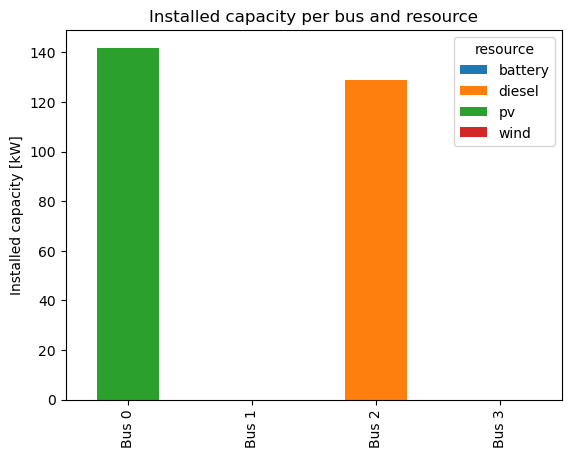

In [19]:
grouped_data = pd.concat([
    n.generators.groupby(["bus", n.generators.index.rename("resource")]).p_nom_opt.sum(),
    n.storage_units.groupby(["bus", n.storage_units.index.rename("resource")]).p_nom_opt.sum(),
])
(
    grouped_data
    .reset_index()
    .pivot(index="bus", columns="resource")
    .reindex(n.buses.index)
    .droplevel(0, axis=1)
    .plot(
        kind="bar",
        stacked=True,
        ylabel="Installed capacity [kW]",
        title="Installed capacity per bus and resource",
        xlabel="",
    )
)

### 5.3 Collect major energy statistics

In the following, the goal is to collect major statistics on the total energy produced to supply the load.

Note that the time series of any quantity of the different objects is stored into the object `{object}_t`, where `{object}` is any pypsa component, such as generators, links, etc.

To do this, we first create a dataframe that contains all time series for any object and then we sum the quantities to identify the desired quantities.

In [20]:
all_dispatch = pd.concat(
    [
        n.generators_t.p,
        n.storage_units_t.p,
        n.stores_t.p,
    ],
    axis=1,
)

total_dispatch = all_dispatch.sum()

Let's compare the quantities with respect to the total demand

In [21]:
total_demand = n.loads_t.p_set.values.sum()

total_dispatch/total_demand

name
pv         0.328323
wind       0.000000
diesel     0.671677
battery    0.000000
dtype: float64

Let's now check the total renewable curtailment by comparing the available renewable production versus the actual production.

In [22]:
# get RES technologies that are actually installed
existing_RES_techs = n.generators.index.intersection(["pv", "wind"])

total_available_RES = n.generators_t.p_max_pu[existing_RES_techs].sum() * n.generators.p_nom_opt[existing_RES_techs]
total_available_RES

name
pv      7382.78244
wind       0.00000
dtype: float64

In [23]:
RES_curtailment = total_available_RES - total_dispatch[existing_RES_techs]

RES_curtailment/total_available_RES

name
pv      0.294064
wind         NaN
dtype: float64

### 5.4 Plot the energy dispatch

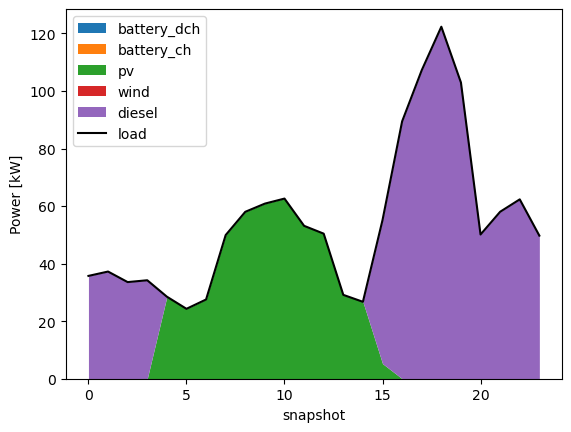

In [27]:
# Day to start the plotting from
init_day_plot = 0
# Number of days to plot
n_days_to_plot = 1

subset_sns = n.generators_t.p.index[init_day_plot*24:(init_day_plot*24 + n_days_to_plot*24)]

# collect discharge power of storages
p_dch_stores = n.storage_units_t.p.loc[subset_sns, :].clip(lower=0.0)  # negative values become 0.0
p_dch_stores.columns = p_dch_stores.columns + "_dch"

# collect charge power of storages
p_ch_stores = n.storage_units_t.p.loc[subset_sns, :].clip(upper=0.0)  # positive values become 0.0
p_ch_stores.columns = p_ch_stores.columns + "_ch"

# create a dataframe to plot the quantities to plot
data_to_plot = pd.concat(
    [
        p_dch_stores,
        p_ch_stores,
        n.generators_t.p.loc[subset_sns, :],
    ],
    axis=1,
)


ax = data_to_plot.plot.area(linewidth=0.0) #, figsize=FIGSIZE)

plt.plot(df_data.loc[subset_sns, ["demand 1", "demand 2"]].sum(axis=1), label="load", color="k")
plt.ylabel("Power [kW]")
plt.legend()

### 5.54 Plot line dispatch

Plot of power exiting the bus0 of each line

<Axes: xlabel='snapshot', ylabel='Line power flow [kW]'>

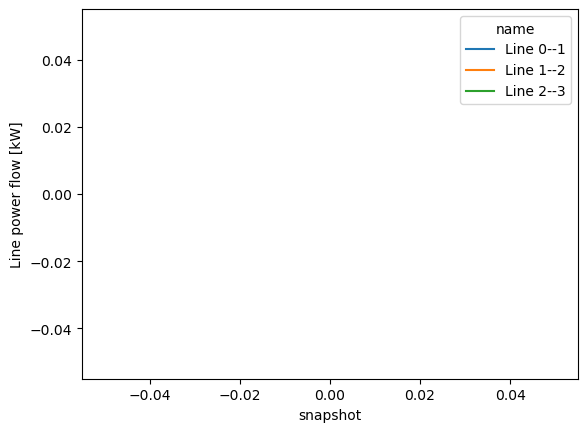

In [25]:
n.lines_t.p0.loc[subset_sns, :].plot(ylabel="Line power flow [kW]")

Plot of power exiting the bus1 of each line (the converse of the previous plot)

<Axes: xlabel='snapshot', ylabel='Line power flow [kW]'>

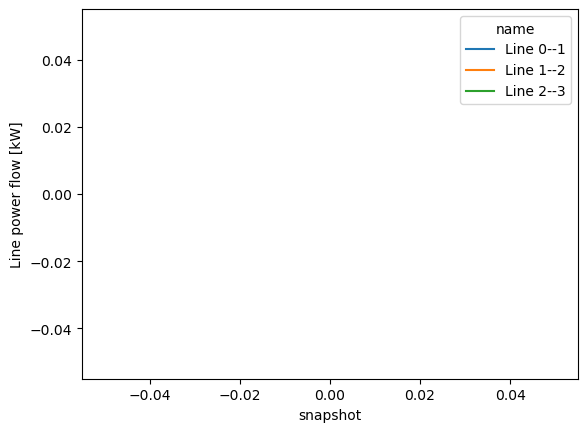

In [26]:
n.lines_t.p1.loc[subset_sns, :].plot(ylabel="Line power flow [kW]")